<a href="https://colab.research.google.com/github/SarithaSundaresan/WineQuality/blob/main/cloud_classification_Jul14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import keras
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

In [3]:
print(tf.__version__)
print(keras.__version__)

#print(tf.config.list_physical_devices('GPU'))

2.12.0
2.12.0


In [6]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)
ROOT_DIR = "/content/drive/MyDrive/Assg2"

Mounted at /content/drive


In [7]:
### CREATE DIRECTORY FOR TRAING & TEST DATASET ###
TRAIN_IMGS_PATH = os.path.join(ROOT_DIR, "train_images_sm1")
TRAIN_IMAGE_MASKS_PATH = os.path.join(ROOT_DIR, "train.csv")
TEST_IMGS_PATH = os.path.join(ROOT_DIR, "test_images")

CLOUD_TYPES = ["Fish","Flower","Gravel","Sugar"]
### PRINT NO OG IMAGES IN TEST AND TRAIN ####
num_train_images = len(os.listdir(TRAIN_IMGS_PATH))
print("No of Train Images:", num_train_images)
num_test_images = len(os.listdir(TEST_IMGS_PATH))
#print("No of Test Images:",num_test_images)

### Print mask data ###
train_masks = pd.read_csv("/content/drive/MyDrive/Assg2/train.csv")
train_masks.head()


No of Train Images: 190


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [5]:
train_masks.describe()

,Image_Label,EncodedPixels
count,22184,11836
unique,22184,11836
top,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
freq,1,1


In [8]:
## Insert new column to identify the cloud label ##
train_masks.insert(1, "Cloud_Label", "")


In [9]:
#train_masks['Cloud_Label'] = ""
for i in range(0, train_masks["Image_Label"].count()):
  temp_string = (train_masks.iat[i, 0]).split("_",1)
  train_masks.iat[i, 0] = temp_string[0]
  train_masks.iat[i, 1] = temp_string[1]
print(train_masks.head())
train_masks.describe()



   Image_Label Cloud_Label                                      EncodedPixels
0  0011165.jpg        Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg      Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg      Gravel                                                NaN
3  0011165.jpg       Sugar                                                NaN
4  002be4f.jpg        Fish  233813 878 235213 878 236613 878 238010 881 23...


,Image_Label,Cloud_Label,EncodedPixels
count,22184,22184,11836
unique,5546,4,11836
top,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
freq,4,5546,1


In [11]:
# Verification # 3 - Each and every train image file must have a mask entry in the CSV file
train_imgs_list = os.listdir(TRAIN_IMGS_PATH) # Create a list of file names from the train images directory
train_masks_list = train_masks["Image_Label"].unique() # Create a list of unique train image labels from the CSV file
result = all(elem in train_imgs_list for elem in train_masks_list) # Check if the files in the train images directory have a mask in the CSV as required

if(result):
  print("Verification  succeeded - all files have masks as required")
else:
  print("Verification failed - some files and their masks are missing in the CSV file")

Verification failed - some files and their masks are missing in the CSV file


In [12]:
print('There are {} rows in train df.'.format(len(train_masks)))
print('There are {} rows with EncodedPixels.'.format(train_masks.EncodedPixels.count()))
print('There are {} rows where EncodedPixels are null.'.format(len(train_masks) - train_masks.EncodedPixels.count()))

There are 22184 rows in train df.
There are 11836 rows with EncodedPixels.
There are 10348 rows where EncodedPixels are null.


In [14]:
# Print  Labels
fish = train_masks[train_masks['Cloud_Label'] == 'Fish'].EncodedPixels.count()
flower = train_masks[train_masks['Cloud_Label'] == 'Flower'].EncodedPixels.count()
gravel = train_masks[train_masks['Cloud_Label'] == 'Gravel'].EncodedPixels.count()
sugar = train_masks[train_masks['Cloud_Label'] == 'Sugar'].EncodedPixels.count()

print('There are {} fish clouds'.format(fish))
print('There are {} flower clouds'.format(flower))
print('There are {} gravel clouds'.format(gravel))
print('There are {} sugar clouds'.format(sugar))

There are 2781 fish clouds
There are 2365 flower clouds
There are 2939 gravel clouds
There are 3751 sugar clouds


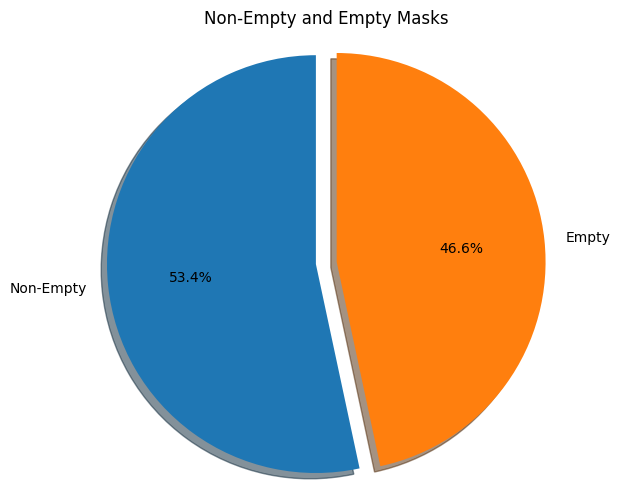

In [16]:
# Ploting a pie chart for Empty and Non-Empty Masks
labels = 'Non-Empty', 'Empty'
sizes = [train_masks.EncodedPixels.count(), len(train_masks) - train_masks.EncodedPixels.count()]
explode = (0,0.1)

figure, axis = plt.subplots(figsize=(6,6))
axis.pie(sizes,explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axis.axis('equal')
axis.set_title('Non-Empty and Empty Masks')

plt.show() # Show the plot

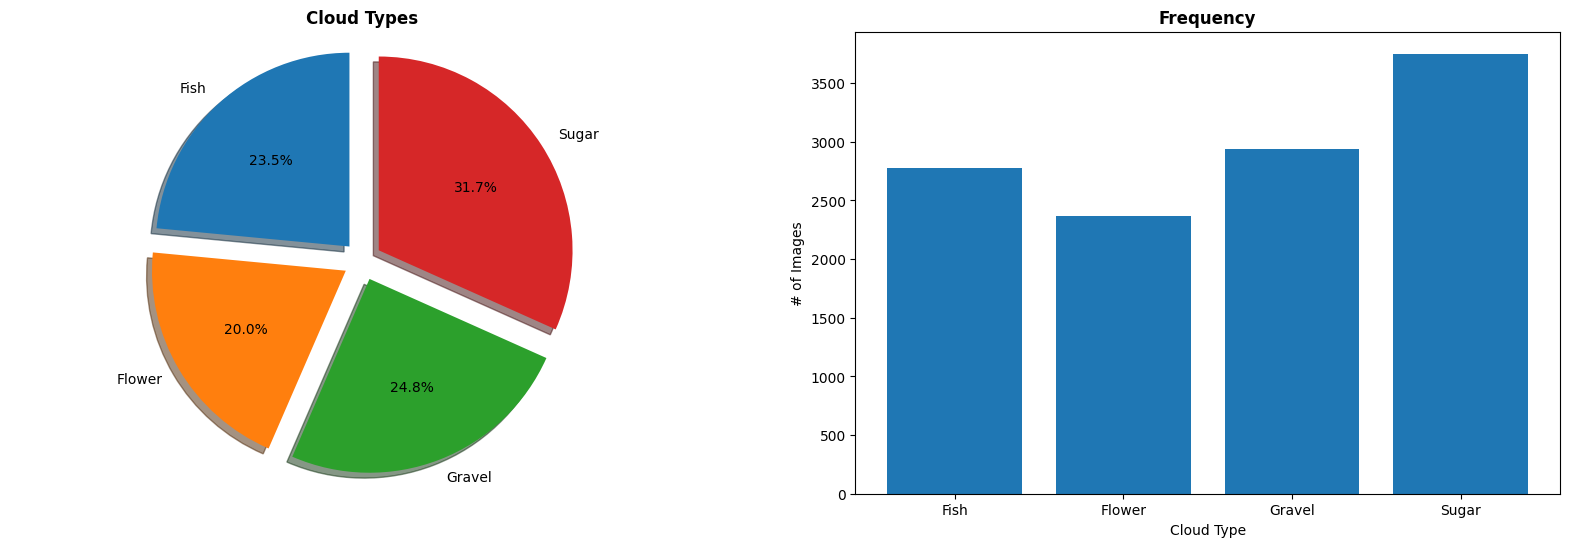

In [17]:
#Plot Cloud types
sizes = [fish, flower, gravel, sugar]
explode = (0.1, 0.1, 0.1, 0.1)

figure, axis = plt.subplots(1,2, figsize=(20,6))
axis[0].pie(sizes, explode=explode, labels=CLOUD_TYPES, autopct='%1.1f%%', shadow=True, startangle=90)
axis[0].axis('equal')
axis[0].set_title('Cloud Types', fontweight='bold')

axis[1].bar(CLOUD_TYPES, sizes)
axis[1].set_title('Frequency', fontweight='bold')
axis[1].set_xlabel('Cloud Type')
axis[1].set_ylabel('# of Images')

plt.show()

In [18]:

## check no of labels in an image

labels_per_image = train_masks.groupby('Image_Label')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 2.134150739271547


Text(0.5, 0, 'How many class lables in a given image')

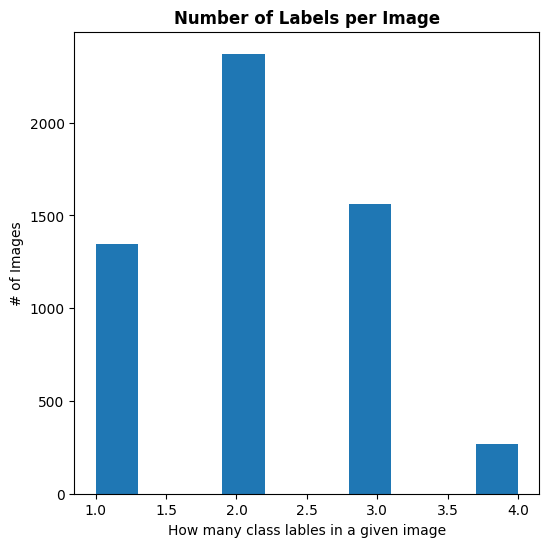

In [19]:
figure, axis = plt.subplots(figsize=(6, 6))
axis.hist(labels_per_image)
axis.set_title('Number of Labels per Image', fontweight='bold')
plt.ylabel("# of Images")
plt.xlabel("How many class lables in a given image")

(1400, 2100, 3)
(1400, 2100, 3)
(1400, 2100, 3)
(1400, 2100, 3)
(1400, 2100, 3)
(1400, 2100, 3)


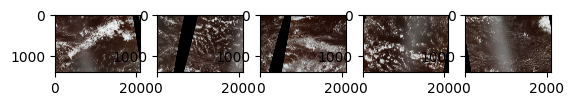

In [20]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
##from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
f, ax = plt.subplots(1, 5)
for  i, file in enumerate(os.listdir("/content/drive/MyDrive/Assg2/train_images_sm1/")[0:6]):
    fullpath = TRAIN_IMGS_PATH+ "/" + file
    #print("path" ,fullpath, i)
    img=cv2.imread(fullpath)
    print(img.shape)
    if i > 0:
     plt.subplot(1, 5, i)
     plt.imshow(img)



In [21]:
# network configuration parameters
# original image is 1600x256, so we will resize it
img_w = 224 # resized weidth
img_h = 224 # resized height
batch_size = 16
epochs = 10
# batch size for training unet
k_size = 3 # kernel size 3x3
val_size = .20 # split of training set between train and validation set
# network hyper parameters
smooth = 1.
dropout_rate = 0.
#train_masks = train_masks.fillna(-1)
train_masks = train_masks.dropna(subset=['EncodedPixels'])
print(train_masks.head())
train_masks.describe()

   Image_Label Cloud_Label                                      EncodedPixels
0  0011165.jpg        Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg      Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
4  002be4f.jpg        Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg      Flower  1339279 519 1340679 519 1342079 519 1343479 51...
7  002be4f.jpg       Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...


,Image_Label,Cloud_Label,EncodedPixels
count,11836,11836,11836
unique,5546,4,11836
top,24dd99c.jpg,Sugar,264918 937 266318 937 267718 937 269118 937 27...
freq,4,3751,1


In [22]:
# This function decodes the given mask as a string input from the CSV File
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
  '''
  Decode rle encoded mask.

  :param mask_rle: run-length as string formatted (start length)
  :param shape: (height, width) of array to return
  Returns numpy array, 1 - mask, 0 - background
  '''
  if(isinstance(mask_rle, str)): # String datatype then it has encoded pixels, extract mask
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
  else: # NaN, Float type, no mask, so zero numpy array
    img = np.zeros((1400, 2100))

  return img.reshape(shape, order='F')

In [23]:
#function to generate the mask using encoded pixels from csv #

def rle_to_mask(rle_string,height,width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters:
    rleString (str): Description of arg1
    height (int): height of the mask
    width (int): width of the mask

    Returns:
    numpy.array: numpy array of the mask
    '''
    rows, cols = height, width
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        #val = math.isnan(int(rle_string))
        #if val == False:
          rleNumbers = [int(numstring) for numstring in rle_string.split(' ')]
          if len(np.array(rleNumbers)) != 1 :
           rlePairs = np.array(rleNumbers).reshape(-1,2)
           img = np.zeros(rows*cols,dtype=np.uint8)
           for index,length in rlePairs:
              index -= 1
              img[index:index+length] = 255
           img = img.reshape(cols,rows)
           img = img.T
           return img

In [24]:
#train_set_list = load_dataset(TRAIN_IMGS_PATH, train_set) # load the dataset by specifying the train directory
#train_set_list.prepare()
#print('Train: %d' % len(train_set_list.image_ids))


# Thanks to the authors of: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask_to_rle(mask):
    '''
    Convert a mask into RLE

    Parameters:
    mask (numpy.array): binary mask of numpy array where 1 - mask, 0 - background

    Returns:
    sring: run length encoding
    '''
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [25]:
# This function decodes the given mask as a string input from the CSV File
def rle_decode(mask_rle,height,width):
  '''
  Decode rle encoded mask.

  :param mask_rle: run-length as string formatted (start length)
  :param shape: (height, width) of array to return
  Returns numpy array, 1 - mask, 0 - background
  '''
  if(isinstance(mask_rle, str)): # String datatype then it has encoded pixels, extract mask
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
  else: # NaN, Float type, no mask, so zero numpy array
    img = np.zeros((1400, 2100))
    img.reshape(height,width)
    img = img.T
    return img


In [26]:
class DataGenerator(Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=16,
                 img_h=224, img_w=224, shuffle=True):

        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)

    def __getitem__(self, index):
        'generate one batch of data'
        #print("****************" ,index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        #print(list_ids_temp[0])
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data
        return X, y

    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        image_resized = 0.0
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        #print(" __data_generation inside ")
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            if image is not None :
              try:
                image_resized = cv2.resize(image, (self.img_w, self.img_h))
                image_resized = np.array(image_resized, dtype=np.float64)
                # standardization of the image
                image_resized -= image_resized.mean()
                image_resized /= image_resized.std()
                #img_h = cv2.flip(img, 1)
              except Exception as e:
                print(str(e))

              mask = np.empty((img_h, img_w, 4))
              for idm, image_class in enumerate(['Fish', 'Flower', 'Gravel', 'Sugar']):


                  temp = train_masks[train_masks.Image_Label == id]
                  for i in range(0,len(temp.values)): # loop through all matching values in frame
                    cloud_type = temp.values[i][1] # extract cloud type
                    rle = temp.values[i][2] # extract encoded pixels
                    #mask_image = rle_decode(encoded_pix)
                    # if there is no mask create empty mask
                    if rle == -1:
                      class_mask = np.zeros((2100, 1400))
                    else:
                      class_mask = rle_to_mask(str(rle), width=2100, height=1400)
                      try:
                        #if(class_mask != None)
                        class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                      except Exception as e:
                        print(str(e))
                      mask[...,idm] = class_mask_resized
                      #print(" image_resized  ************* ",image_resized)

              X[idx,] = np.expand_dims(image_resized, axis=2)
              y[idx,] = mask

        # normalize Y
        y = (y > 0).astype(int)
        return X, y

In [27]:

# Split the train set into 80% training and 20% validation set
#train_set, val_set = split_dataset(train_imgs_list, 0.80)

train_image_ids = train_masks['Image_Label'].unique()
X_train, X_val = train_test_split(train_image_ids, test_size=.20, random_state=42)

In [28]:
def viz_cloud_img_mask(img, masks):
    img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20,10))
    cmaps = ["Reds", "Blues", "Greens", "Purples"]
    for idx, mask in enumerate(masks):
        ax[idx].imshow(img)
        ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])

In [29]:
masks = {}
for index, row in train_masks[train_masks['EncodedPixels']!=-1].iterrows():
    #masks[row['Image_Label']] = row['EncodedPixels']
    masks[row['Cloud_Label']] = row['EncodedPixels']

In [30]:
params = {'img_h': img_h,
          'img_w': img_w,
          'image_dir': TRAIN_IMGS_PATH,
          'batch_size': 16,
          'shuffle': True,          }

# Get Generators
training_generator = DataGenerator(X_train, masks, **params)
validation_generator = DataGenerator(X_val, masks, **params)


In [31]:
#x, y = training_generator.__getitem__(0)
x, y = training_generator.__getitem__(0)
print(x.shape, y.shape)

for ix in range(0,batch_size):
    if y[ix].sum() > 0:
        #print("newww")
        img = x[ix]
        masks_temp = [y[ix][...,i] for i in range(0,4)]
        viz_cloud_img_mask(img, masks_temp)

(16, 224, 224, 3) (16, 224, 224, 4)


In [32]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout

def conv_block(inputs,filterCount):
    x = Conv2D(filterCount * 2,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount * 2,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    return x

In [33]:
def decoder_block(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    x = Concatenate()([x, skip_features])
    return x

In [34]:

def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor = inputs)
    for layer in vgg16.layers:
     layer.trainable = False
    # the encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    print(skip1.shape)
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    # the center
    center = vgg16.get_layer("block5_conv3").output

    # the decoder
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    prediction = Dense(4, activation='softmax')(d4)
    model = Model(inputs=vgg16.input, outputs=prediction)
    return model



In [35]:
input_shape = (224,224,3)
model = unet_vgg16(input_shape)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
(None, 224, 224, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
        

In [2]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [3]:
#from tensorflow.keras import mixed_precision
#from tensorflow.keras import backend as K
# Configure optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Enable mixed precision optimizer
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = [dice_coef, 'accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])




NameError: ignored

In [ ]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=10, batch_size=16)
#model.save('/content/drive/MyDrive/Assg2/vggunetModel_14.h5')
#print('Model Saved!')


Epoch 1/10
 58/277 [=====>........................] - ETA: 5:59:38 - loss: nan - accuracy: 0.7758

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


# summarize history for accuracy
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
from tensorflow.keras.models import load_model

# load model
#savedModel=load_model('/content/drive/MyDrive/Assg2/vggunetMode15.h5')
#savedModel.summary()

In [ ]:
#loss, acc = savedModel.evaluate(test_images, test_labels, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [ ]:
# a function to plot image with mask and image with predicted mask next to each other
def viz_single_fault(img, mask, pred, image_class):

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,5))

    cmaps = ["Reds", "Blues", "Greens", "Purples"]

    ax[0].imshow(img)
    ax[0].imshow(mask, alpha=0.3, cmap=cmaps[image_class-1])
    ax[0].set_title('Mask - Defect Class %s' % image_class)

    ax[1].imshow(img)
    ax[1].imshow(pred, alpha=0.3, cmap=cmaps[image_class-1])
    ax[1].set_title('Predicted Mask - Defect Class %s' % image_class)

    plt.show()

In [ ]:
make_submission = False
if make_submission == False:
    # lets loop over the predictions and print 5 of each image cases with defects
    count = 0
    # a list to keep count of the number of plots made per image class
    class_viz_count = [0,0,0,0]
    # to keep the total iou score per image class
    class_iou_score = [0, 0, 0, 0]
    # to keep sum of mask pixels per image class
    class_mask_sum = [0, 0, 0, 0]
    # to keep sum of predicted mask pixels per image class
    class_pred_sum = [0, 0, 0, 0]

    # loop over to all the batches in one epoch
    for i in range(0, validation_generator.__len__()):
        # get a batch of image, true mask, and predicted mask

        x, y = validation_generator.__getitem__(i)
        predictions = model.predict(x)

        # loop through x to get all the images in the batch
        for idx, val in enumerate(x):
            #print("inside 2st for loop")
            # we are only interested if there is a fault. if we are dropping images with no faults before this will become redundant
            # if y[idx].sum() > 0:
                #print("inside y[idx].sum() for loop")
                # get an image and convert to make it matplotlib.pyplot friendly
                img = x[idx]
                img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2RGB)
                # loop over the four ourput layers to create a list of all the masks for this image
                masks_temp = [y[idx][...,i] for i in range(0,4)]
                # loop over the four output layers to create a list of all the predictions for this image
                preds_temp = [predictions[idx][...,i] for i in range(0,4)]
                # turn to binary (prediction) mask
                preds_temp = [p > .5 for p in preds_temp]

                for i, (mask, pred) in enumerate(zip(masks_temp, preds_temp)):

                    image_class = i + 1
                    #class_iou_score[i] += calculate_iou(mask, pred)
                    class_mask_sum[i] += mask.sum()
                    class_pred_sum[i] += pred.sum()
                    #print("mask.sum() ****", mask.sum())
                    #print("class_viz_count[i] **********" class_viz_count[i])
                    if mask.sum() > 0 and class_viz_count[i] < 5:

                        viz_single_fault(img, mask, pred, image_class)
                        class_viz_count[i] += 1

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)
    print( "***********", mask)
    mask = (mask[0] > 0.5)*1
    #print(np.unique(mask,return_counts=True))

    mask = np.reshape(mask,(224,224,3))
    return mask

In [ ]:
image = TRAIN_IMGS_PATH +"/0a380d0.jpg"
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

In [ ]:
mask = make_prediction(savedModel,image,(224,224,3))
mask2 = cv2.merge([mask,mask,mask]).astype('float32')
print(img.shape,mask2.shape)
mask2 = cv2.resize(mask2,(img.shape[1],img.shape[0]))
# print(mask.shape)
plt.imshow(mask2)

In [ ]:
# return tensor in the right shape for prediction
def get_test_tensor(img_dir, img_h, img_w, channels=1):

    X = np.empty((1, img_h, img_w, channels))
    # Store sample
    image = cv2.imread(img_dir, 0)
    image_resized = cv2.resize(image, (img_w, img_h))
    image_resized = np.array(image_resized, dtype=np.float64)
    # normalize image
    image_resized -= image_resized.mean()
    image_resized /= image_resized.std()

    X[0,] = np.expand_dims(image_resized, axis=2)

    return X

In [ ]:
## code for submission file

import glob
# get all files using glob
test_files = [f for f in glob.glob(ROOT_DIR +'/test_images/' + "*.jpg", recursive=True)]
submission = []

# a function to apply all the processing steps necessery to each of the individual masks
def process_pred_mask(pred_mask):

    pred_mask = cv2.resize(pred_mask.astype('float32'),(1600, 256))
    pred_mask = (pred_mask > .5).astype(int)
    #pred_mask = remove_small_regions(pred_mask, 0.02 * np.prod(512)) * 255
    pred_mask = mask_to_rle(pred_mask)

    return pred_mask

# loop over all the test images
for f in test_files:
    # get test tensor, output is in shape: (1, 256, 512, 3)
    test = get_test_tensor(f, img_h, img_w)
    # get prediction, output is in shape: (1, 256, 512, 4)
    pred_masks = model.predict(test)
    # get a list of masks with shape: 256, 512
    pred_masks = [pred_masks[0][...,i] for i in range(0,4)]
    # apply all the processing steps to each of the mask
    pred_masks = [process_pred_mask(pred_mask) for pred_mask in pred_masks]
    # get our image id
    id = f.split('/')[-1]
    # create ImageId_ClassId and get the EncodedPixels for the class ID, and append to our submissions list
    [submission.append((id+'_%s' % (k+1), pred_mask)) for k, pred_mask in enumerate(pred_masks)]
